In [1]:
import torchvision.models as models                   

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
# import json
# import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
import torch.nn as nn
# from scipy.ndimage import gaussian_filter
# from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )
# convert image from 
def image_converter(im):
    im_copy = im.cpu()
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    return im_copy

def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [32]:
def act_max(model, 
    inp_img, 
    layer_activation, 
    layer_name, 
    unit, 
    steps=5, 
    alpha=torch.tensor(0.005),
    theta_decay=0.1,
    theta_every=4,
    theta_width=0.1,
    ):

    best_activation = -float('inf')
    best_img = inp_img
    for k in range(steps):
        inp_img.requires_grad_(True)
        inp_img.retain_grad() 
        
        # Propogate image
        model(inp_img)
        layer_out = layer_activation[layer_name]

        # compute gradients
        layer_out[0][unit].backward(retain_graph=True)
        img_grad = inp_img.grad

        # Gradient Step
        inp_img = torch.add(inp_img, torch.mul(img_grad, alpha))

        # #L2_Decay
        # input = torch.mul(input, (1.0 - theta_decay))


        # #Gaussian Blurr
        # if k % theta_every is 0:
        #     temp = input.squeeze(0)
        #     temp = temp.detach().numpy()
        #     for channel in range(3):
        #         cimg = gaussian_filter(temp[channel], theta_width)
        #         temp[channel] = cimg
        #     temp = torch.from_numpy(temp)
        #     input = temp.unsqueeze(0)

        # print('step: ', k, 'activation: ', layer_out[0][unit])
        # if k % 10 == 0:
        if k == steps - 1:
            final_image = image_converter(inp_img.squeeze(0))
            plt.imshow(final_image)
            plt.show()
            print('step: ', k, 'activation: ', layer_out[0][unit])

        # Keep highest activation
        # Some sort of penalization for high-activation-inputs generating high-activation-outputs: why 0.05? why linear?
        if layer_out[0][unit] - (0.05 * torch.norm(inp_img)) > best_activation:
            best_activation = layer_out[0][unit]
            best_img = inp_img
    return (best_activation, best_img)

In [4]:
from numpy import asarray, percentile, tile
def load_image(img_path, device=False):
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = img.convert('RGB')
    img = asarray(img).transpose(-1, 0, 1)
    img = img/255
    img = torch.from_numpy(img) 
    img = normalize(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    if device:
        img = img.type(torch.cuda.FloatTensor)
    else:
        img = img.type(torch.FloatTensor)
    return img

In [6]:
resnet50 = models.resnet50(pretrained = True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\phili/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
alexnet = models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval().to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# uris = [
#     'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
# ]
# uri = 'https://salient-imagenet.cs.umd.edu/feature_visualization/class_130/feature_484/images/0.jpg'
# input = utils.prepare_input_from_uri(uri).to(device)
def reset_img():
  # inp = load_image('flamingo_image.jpg')
  inp = torch.rand((1, 3, 227, 227))
  inp.requires_grad_(True)
  return inp

In [30]:
# starting image
orig_img = reset_img()
inp = orig_img
# outputs of image through both neural nets
results = [resnet50(inp), alexnet(inp)]
values = [res.detach().numpy() for res in results]
# max outputs of image through both neural nets
ks = [max(v[0]) for v in values]

In [28]:
act_dicts = [{}, {}]
layer_name = 'classifier_final'
(list(resnet50.children())[-1].register_forward_hook(layer_hook(act_dicts[0], layer_name)),
 list(alexnet.children())[-1].register_forward_hook(layer_hook(act_dicts[1], layer_name)))

(<torch.utils.hooks.RemovableHandle at 0x1c587bd0b10>,
 <torch.utils.hooks.RemovableHandle at 0x1c5d8c70310>)

In [54]:
# which class each network predicted the original image as
units = [list(values[i][0]).index(ks[i]) for i in range(2)]
# If we start with randomized image [0,1], we manually set the target class
# 112: conch
# 130: flamingo
units = [130, 130]
print(units)   
# print(inp)    

# some kind of transformation to input image?


# print(inp)

[130, 130]


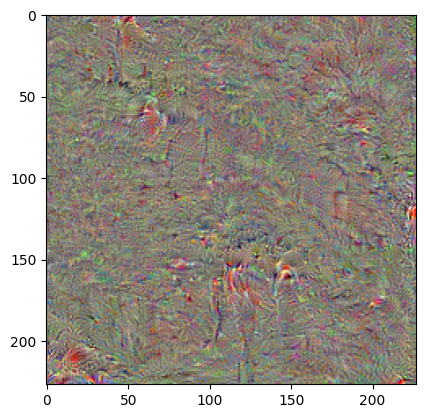

step:  199 activation:  tensor(229.2727, grad_fn=<SelectBackward0>)


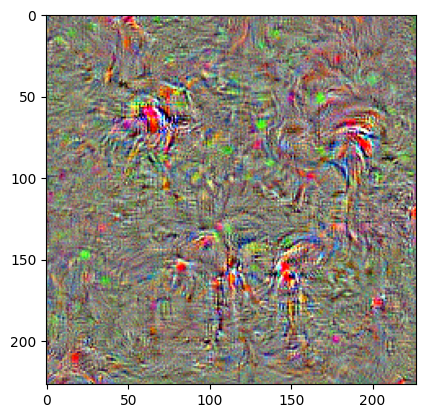

step:  99 activation:  tensor(677.5434, grad_fn=<SelectBackward0>)


In [55]:
alpha = torch.tensor(1)
inp = torch.add(orig_img, torch.norm(inp, float('inf')), alpha = (-1)*0.1)
activation1, output1 = act_max(model=resnet50,
                inp_img=inp,
                layer_activation=act_dicts[0],
                layer_name=layer_name,
                unit=units[0],
                steps=200,
                alpha=alpha,
                )
inp = torch.add(orig_img, torch.norm(inp, float('inf')), alpha = (-1)*0.1)
activation2, output2 = act_max(model=alexnet,
                inp_img=inp,
                layer_activation=act_dicts[1],
                layer_name=layer_name,
                unit=units[1],
                steps=100,
                alpha=alpha,
                )

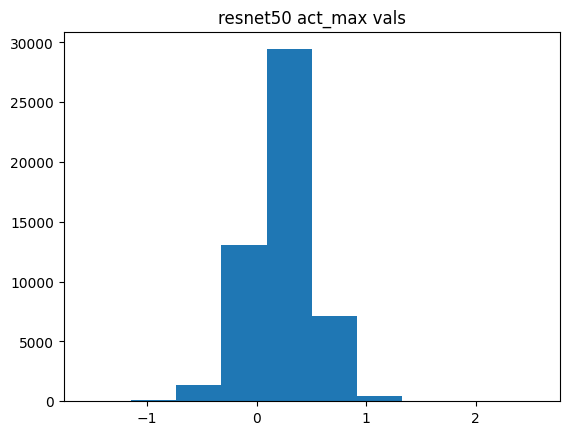

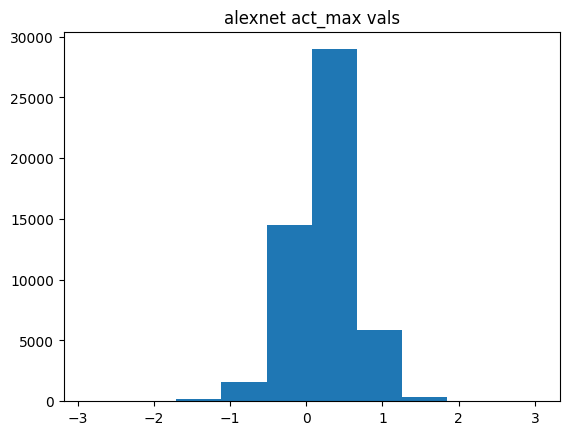

(None, None)

In [53]:
# print(output1.shape)
# convert (1, 3, 227, 227) Torch tensor into 227*227 element numpy array, averaging across RGB channels
def np_data(img):
    img = img.squeeze()
    img = torch.mean(img, 0)
    img = torch.flatten(img)
    img = img.detach().numpy()
    return img
def get_hist(arr, title):
    hist, bin = np.histogram(arr)
    plt.hist(arr, bins=bin)
    plt.title(title)
    plt.show()
out1, out2 = np_data(output1), np_data(output2)
get_hist(out1, title='resnet50 act_max vals'), get_hist(out2, title='alexnet act_max vals')